# River Level Forecasting 
Proof on concept by Orion Junkins for ongoing research under Patrick Donnelly

In [2]:
verbose = True # Toggles a variety of print statements to aid understanding

***
# Load packages 
***

In [3]:
# Import needed packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


***
# Data
***

In [4]:
def yesterday():
  # Helper function for data retrieval
  # Returnss yesterdays date in the format "%Y-%m-%d"
  yesterday = datetime.today()  - timedelta(days=1)
  yesterday = yesterday.strftime("%Y-%m-%d")
  return yesterday

### Load datasets


In [5]:
# Fetch both relevant datasets if they have not been fetched already
try:
  if data_grabbed:
    pass  
except NameError:
  # Fetch weather & SWE data for Mckenzie basin. Atuomatically retrieves all data up to present.
  url_weather ='https://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/619:OR:SNTL%7Cid=%22%22%7Cname/POR_BEGIN,POR_END/WTEQ::value,PREC::value,TMAX::value,TMIN::value,TAVG::value,PRCP::value'
  weather_data = pd.read_csv(url_weather, comment='#')  

  # Based on today's date, fetch all relevant water data
  url_river_level = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=14162500&referred_module=sw&period=&begin_date=1988-10-12&end_date=' + yesterday()
  river_level_data = pd.read_csv(url_river_level, sep='\t', comment='#')  

  # Raise the data_grabbed flag so data will not be grabbed again until runtime is reset
  data_grabbed = True  

### Pre-process river level dataset

In [6]:
# Drop un-needed metadata
df_levels = river_level_data.drop(columns=['agency_cd', 'site_no', '172063_00060_00003_cd'])
df_levels.drop(0, inplace=True)

# Convert the datetime column to datetime objects
df_levels["datetime"] = pd.to_datetime(df_levels["datetime"])

# Use the datetime column as the index
df_levels.set_index('datetime', inplace=True)

# Rename the level column
df_levels.rename(columns={'172063_00060_00003':'level'}, inplace=True)

# Cast the level column to type float
df_levels['level'] = df_levels['level'].astype(float)

# Display the levels data
if verbose: 
  display(df_levels)

,level
datetime,
1988-10-12,2230.0
1988-10-13,2240.0
1988-10-14,2000.0
1988-10-15,1770.0
1988-10-16,1770.0
...,...
2021-12-28,5040.0
2021-12-29,4260.0
2021-12-30,4010.0


### Pre-process weather dataset

In [7]:
# Drop un-needed metadata
df_weather = weather_data.drop(columns=['Precipitation Accumulation (in) Start of Day Values'])

# Renamne the date column to match levels data
df_weather.rename(columns={'Date':'datetime'}, inplace=True)

# Convert the datetime column into datetime objects
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

# Use the datetime column as the index
df_weather.set_index('datetime', inplace=True)

# Display the weather data
if verbose: 
  display(df_weather)

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in)
datetime,,,,,
1980-11-03,NaN,NaN,NaN,NaN,NaN
1980-11-04,NaN,NaN,NaN,NaN,NaN
1980-11-05,NaN,NaN,NaN,NaN,NaN
1980-11-06,NaN,NaN,NaN,NaN,NaN
1980-11-07,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-12-29,13.4,30.0,15.0,25.0,0.1
2021-12-30,13.6,28.0,19.0,25.0,1.3
2021-12-31,15.2,NaN,NaN,NaN,0.3


### Combine and further pre-process all data

In [8]:
# Merge both processed dataframes into a single dataframe
df = pd.merge(df_weather, df_levels, on="datetime")

In [9]:
#Create a new column containing the level from the previous day
df['level_yesterday'] = np.nan
rows = df.shape[0]
for row_idx in range(1, rows):
 df['level_yesterday'][row_idx] = df['level'][row_idx-1]

# Swap the final two columns so that current level is rightmost
columns_titles = ['Snow Water Equivalent (in) Start of Day Values',
       'Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)',
       'Air Temperature Average (degF)', 'Precipitation Increment (in)', 'level_yesterday',
       'level']
df=df.reindex(columns=columns_titles)

In [10]:
# Impute NaNs by averaging backfilled and forward filled approachess
# Essentially, this will average nearest non NaN neighbors on either side sequentially

# Compute forward/back filled data
for_fill = df.fillna(method='ffill')
back_fill = df.fillna(method='bfill')

# For every column in the dataframe,
for col in df.columns:
  # Average the forward and back filled values
  df[col] = (for_fill[col] + back_fill[col])/2

# Drop any rows remaining which have NaN values (generally first and/or last rows)
df.dropna(inplace=True)

# Confirm imputation worked
assert(df.isna().sum().sum() == 0)

# Display the dataframe in its current state
if verbose: 
  display(df.head(50))

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),level_yesterday,level
datetime,,,,,,,
1988-10-13,0.0,32.0,32.0,32.0,0.2,2230.0,2240.0
1988-10-14,0.0,32.0,32.0,32.0,0.0,2240.0,2000.0
1988-10-15,0.0,32.0,32.0,32.0,0.0,2000.0,1770.0
1988-10-16,0.0,32.0,32.0,32.0,0.0,1770.0,1770.0
1988-10-17,0.0,32.0,32.0,32.0,0.0,1770.0,1760.0
1988-10-18,0.0,32.0,32.0,32.0,0.0,1760.0,1760.0
1988-10-19,0.0,32.0,32.0,32.0,0.0,1760.0,1910.0
1988-10-20,0.0,32.0,32.0,32.0,0.2,1910.0,2340.0
1988-10-21,0.0,32.0,32.0,32.0,0.0,2340.0,2670.0


In [11]:
# Perform min-max scaling on all columns
# Create the scaler for feature data
scaler = MinMaxScaler()

# For every feature column,
for column in df.columns[:-1]:
  # fit and transform the data
  df[[column]] = scaler.fit_transform(df[[column]])

# Create a separate scaler for target data 
target_scaler = MinMaxScaler()

# Scale the target column
target_col = df.columns[-1]
df[[target_col]] = target_scaler.fit_transform(df[[target_col]])

# Describe the newly scaled dataframe
if verbose: 
  df.describe()

In [12]:
def build_input(X, y, seq_len=5):
  # Adapted from: https://towardsdatascience.com/predictive-analysis-rnn-lstm-and-gru-to-predict-water-consumption-e6bb3c2b4b02
  # Takes raw X, y data as input, and generates X sequences of the given length

  # Create two empty output arrays
  X_out, y_out = [], []

  # Number of individual data entries
  num_samples = len(X)
  
  # Number of complete sequences to be generated (note: sequences overlap, with starts offset by 1)
  num_complete_sequences = num_samples-seq_len

  # For every sequence index
  for seq_idx in range(num_complete_sequences):

    # Grab a full seq_len of feature data starting at X[seq_idx]
    cur_seq = X[seq_idx:seq_idx+seq_len, :]

    # Append feature data to X_out
    X_out.append(cur_seq)

    # Append the corresponding output value to y_out 
    y_out.append(y[seq_idx+seq_len])

    # Return X_out and y_out as np array_out
  return np.array(X_out), np.array(y_out)

In [13]:
# Separate X (features) data from y (target) values 
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# Build X, y input sequences out of raw X, y data
X, y = build_input(X, y)

In [14]:
# Split the resulting data into train and test splitss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [15]:
# Add an extra dimension to match input_shape of Conv2D model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

***
# Model
***

In [16]:
def build_conv_model():
  # Helper function for building a basic convolutional NN model
  # Create the model
  model = tf.keras.Sequential()

  # Add desired layers
  model.add(layers.Conv2D(16, (2,2), input_shape=X_train[0].shape))
  model.add(layers.Dropout(0.1))
  model.add(layers.Conv2D(32, (2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  # Compile the model
  model.compile(loss='mse', optimizer='adam')

  # Return the model
  return model

In [17]:
# Build a model
basic_conv_model = build_conv_model()

# Fit the model
basic_conv_model.fit(X_train, y_train, epochs = 20, batch_size = 10, 
                        shuffle = True)

Epoch 1/20
971/971 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 2/20
971/971 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 3/20
971/971 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 4/20
971/971 [==============================] - 2s 2ms/step - loss: 0.0014
Epoch 5/20
971/971 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 6/20
971/971 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 7/20
971/971 [==============================] - 2s 2ms/step - loss: 0.0013
Epoch 8/20
152/971 [===>..........................] - ETA: 1s - loss: 9.9746e-04

KeyboardInterrupt: 

In [18]:
def build_conv_LSTM_model():
  # Helper function for building a convolutional LSTM NN model
  # Create the model
  model = tf.keras.Sequential()

  # Add desired layers
  model.add(layers.ConvLSTM2D(16, 2, input_shape=(5, 6, 1, 1), padding='same', return_sequences=True))
  model.add(layers.Dropout(0.1))
  model.add(layers.ConvLSTM2D(32, 2, input_shape=(5, 6, 1, 1), padding='same', return_sequences=True))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  # Compile the model
  model.compile(loss='mse', optimizer='adam')

  # Return the model
  return model

In [19]:
# Build a model
conv_LSTM_model=build_conv_LSTM_model()

# Add an extra dimension to match input_shape of Conv LSTM 2D model
X_train_5D = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1, 1)
X_test_5D = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1)

# Fit the model
conv_LSTM_model.fit(X_train_5D, y_train, epochs = 200, batch_size = 2048, 
                        shuffle = True)

Epoch 1/200
5/5 [==============================] - 3s 73ms/step - loss: 0.0169
Epoch 2/200
5/5 [==============================] - 0s 49ms/step - loss: 0.0101
Epoch 3/200
5/5 [==============================] - 0s 54ms/step - loss: 0.0096
Epoch 4/200
5/5 [==============================] - 0s 56ms/step - loss: 0.0089
Epoch 5/200
5/5 [==============================] - 0s 56ms/step - loss: 0.0086
Epoch 6/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0084
Epoch 7/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0079
Epoch 8/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0076
Epoch 9/200
5/5 [==============================] - 0s 50ms/step - loss: 0.0071
Epoch 10/200
5/5 [==============================] - 0s 50ms/step - loss: 0.0067
Epoch 11/200
5/5 [==============================] - 0s 49ms/step - loss: 0.0060
Epoch 12/200
5/5 [==============================] - 0s 50ms/step - loss: 0.0054
Epoch 13/200
5/5 [==============================]

## Experiment(s)

In [21]:
# Helper function for plotting y_pred vs y_true over a given day range
def plot_predictions(y_pred, y_true, start_index=0, end_index=-1):
  plt.plot(y_pred[start_index:end_index], label='y_pred')
  plt.plot(y_true[start_index:end_index], label='y_true')
  plt.legend()
  plt.title("Predicted Level and True Level over time")
  plt.xlabel("Day in Range")
  plt.ylabel("Level (cubic feet per second)")
  plt.show()

In [22]:
def evaluate_model(model, X_test=X_test, y_test=y_test):
  # Print a general model evaluation in the given X, y sets
  print("Test set loss:")
  print(model.evaluate(x=X_test, y=y_test))
  print()
  print()

  # Generate raw predictions for the given X test data
  y_pred = np.array(model(X_test))

  # Inverse transfrom y_pred and y_test values back into cfs (undo MinMax scaling)
  y_pred = target_scaler.inverse_transform(y_pred)
  y_true = target_scaler.inverse_transform(y_test.reshape(-1, 1))

  # Plot the predictions for the past 40 days
  print("Predictions and true values for past 40 days:")
  plot_predictions(y_pred, y_true, start_index=-40)
  print()

  # Plot the predictions for the past 100 days
  print("Predictions and true values for past 100 days:")
  plot_predictions(y_pred, y_true, start_index=-100)

Test set loss:
76/76 [==============================] - 0s 2ms/step - loss: 0.0015
0.0014646525960415602


Predictions and true values for past 40 days:


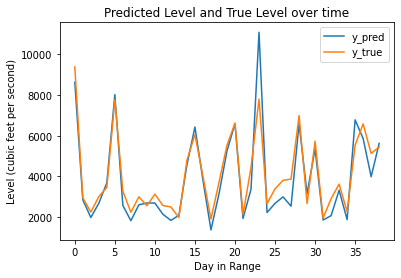


Predictions and true values for past 100 days:


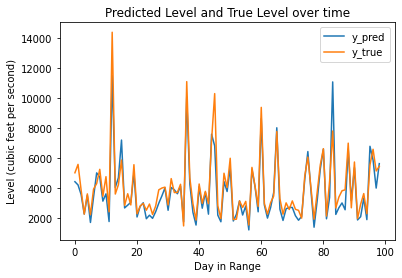

In [23]:
# Evaluate the basic CNN model
evaluate_model(basic_conv_model)

Test set loss:
76/76 [==============================] - 1s 10ms/step - loss: 0.0012
0.0012297757202759385


Predictions and true values for past 40 days:


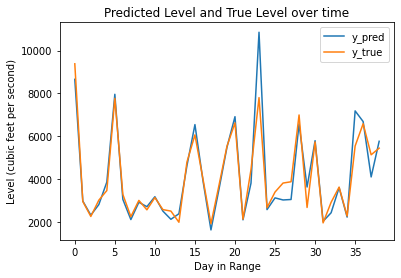


Predictions and true values for past 100 days:


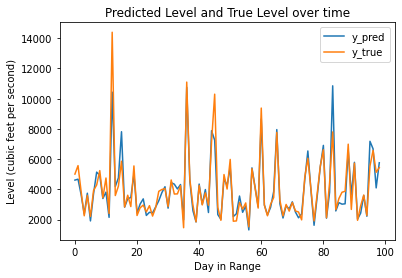

In [24]:
# Evaluate the more complex CNN/RNN model
evaluate_model(conv_LSTM_model, X_test=X_test_5D)

***
# Report: River Level Inference in the McKenzie River Basin
***

## Introduction

Whitewater kayaking a river is a very different experience with different amounts of water. Too little, and hazards/rocks become exposed making it difficult to go downstream. Too much, and hydraulics can become dangerous, with less time in between rapids. For many sections of river, the runnable range between the two extremes is narrow.

River level gauges are fairly widespread, making real time data attainable. However, knowing what will happen in an hour, in 12 hours or over the next several days is critical to safely navigating many runs. Predicting river level accurately can be a matter of life and death, as many gorges do not enable escape in the event of a flash flood. I have personally known paddlers that have passed away in these kinds of situations.

This risk has always been an assumed, inherent part of paddling - you look at current conditions (recent precipitation, weather forecast, current snowpack etc.) and do your best, but it is largely guesswork. 

Paddlers develop an intuition by studying data over years so that, when the time comes, they can make the best guess possible given the current conditions. While the data is trivial to aquire, this intuition is not. This intuition is even harder to express algorithmically, and so previous attempts to forecast river levels have, largely, lacked accuracy.

Neural Networks may offer a better way.



---
**Problem Statement:**

**Given historical weather and river level data for a particular gauge/drainage, can the future level be predicted using a Neural Network?**

---



## Dataset

The Mckenzie River was selected as an example in order to prove the concept of ML level prediction. While the results shown are specific to this river and gauge, the same models should work similarly for any other river with sites that offers the relevant data.

This experiment relied on two datasets:

---
##### SNOTEL 619: Mckenzie, OR, Historical Weather Data
This site is located up high in the Mckenzie watershed and provides the following daily data ranging from 1980 to today:

* Snow Water Equivalent (in) Start of Day Values
* Precipitation Accumulation (in) Start of Day Values
* Air Temperature Maximum (degF)
* Air Temperature Minimum (degF)
* Air Temperature Average (degF)
* Precipitation Increment (in)
---

##### USGS Gauge 14162500 Mckenzie River Neaar Vida, Or
This river level gauge is located near the town of Vida Oregon and offers river data as far back as 1988. It was used to acquire the following data:
* Discharge (flow rate), cubic feet per second (Daily Mean)
---




## Pre-processing

Several steps are perfomed on the data to prepare for inference.


1. Drop columns which are irrelvant in making predictions (ie agency id, site number, year to date precip, etc.).
2. Convert dates to python datetime objects.
3. Index both lists by date.
4. Merge the lists over their shared date range (ie ignore the first 8 years of weather data for which there is no corresponding level data).
5. Extract the 'level_yesterday' as an additional feature to provide an output-input recurrence for the network to learn. This allows the network to make predictions based on the level from the day prior.
6. Impute NaN values by calculating both forward and backfilled versions of the entire dataset, and averaging the values. In esssence this averages the nearest sequential neighbors on either side of a given NaN.
7. MinMax Scale all data to put it in the range [0,1].

The dataset following this processing can be previewed below:

In [25]:
display(df)

,Snow Water Equivalent (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in),level_yesterday,level
datetime,,,,,,,
1988-10-13,0.000000,0.315789,0.572917,0.488889,0.030769,0.034789,0.035176
1988-10-14,0.000000,0.315789,0.572917,0.488889,0.000000,0.035176,0.025899
1988-10-15,0.000000,0.315789,0.572917,0.488889,0.000000,0.025899,0.017008
1988-10-16,0.000000,0.315789,0.572917,0.488889,0.000000,0.017008,0.017008
1988-10-17,0.000000,0.315789,0.572917,0.488889,0.000000,0.017008,0.016622
...,...,...,...,...,...,...,...
2021-12-28,0.157895,0.315789,0.416667,0.422222,0.261538,0.160417,0.143409
2021-12-29,0.160287,0.298246,0.395833,0.411111,0.015385,0.143409,0.113259
2021-12-30,0.162679,0.280702,0.437500,0.411111,0.200000,0.113259,0.103595


8. Separate train and test sets for X and y appropriately by grabbing the first 10000 samples (~83%) for training and saving the remainder (up to present day) for testing.


## Methods (Experiment)

For training, data was batched into sequences of 5 consecutive days, with the level on the 5th day as a single target value. Ie to predict the level on day t, input data from days [t-5, t] is needed.

This 5 day range was chosen by intuition based on prior paddling experience - weather data up to five days prior is very likely to have some impact on the current level. Data older than five days may give a subtle insight, but is more likely to add noise to the dataset while greatly increasing model training time. This was also explored empirically, with lower and higher values both resulting in higher loss.

Initially, a RNN was viewed as the ideal approach given the sequential nature of the data. A variety of LSTM and BLSTM models were trialed, however they failed to yield the accuracy desired. Loss reached levels as low as 0.0015, but no hyperparameter/layer combination was found that went any lower.

Instead, a 2DConv net was used, which very quickly matched and then beat the RNN through tuning. A summary of the final CNN model is shown here:


In [26]:
 basic_conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4, 5, 16)          80        
                                                                 
 dropout (Dropout)           (None, 4, 5, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 4, 32)          2080      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 1)                 385       
                                                                 
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
_________________________________________________________________


While early testing demonstrated a noticeable improvement, using an RNN still made more sense given the problem domain. By using batches with multiple days as input, the Conv2D model retains access to all of the same data, but the sequential information is lost which may provide further insight. 

To address this, a second model was constructed using a ConvLSTM2D layer ([API here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ConvLSTM2D)). This layer is structured the same as a Conv2D, but assumes data is sequential and carries a hidden state throughout the learning process just as an RNN would. The final model after hyperparamter tuning is summarized below:

In [27]:
conv_LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 5, 6, 1, 16)       4416      
                                                                 
 dropout_1 (Dropout)         (None, 5, 6, 1, 16)       0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 5, 6, 1, 32)       24704     
                                                                 
 flatten_1 (Flatten)         (None, 960)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 961       
                                                                 
Total params: 30,081
Trainable params: 30,081
Non-trainable params: 0
_________________________________________________________________


To compare these two models, both were trained on the same data (with some reshaping for the conv_lstm model) for 20 epochs (enough time for both models to converge). Both models were evaluated on the same previously unseen test set to compare losses.

To give context to this evaluation, the test set predictions for both models were extracted and graphed against the actual levels. Graphs were generated for for the most recent 40 days and the most recent 100 days to view the correlation over time.

## Results and Analysis

The basic Conv2D model performed surprisingly well. On this specific test set it achieved a loss of 9.6064e-04 (better than any LSTM/BLSTM model tested). Evaluation results can be seen below:

Test set loss:
76/76 [==============================] - 0s 810us/step - loss: 0.0015
0.0014646525960415602


Predictions and true values for past 40 days:


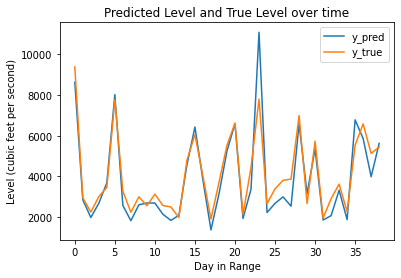


Predictions and true values for past 100 days:


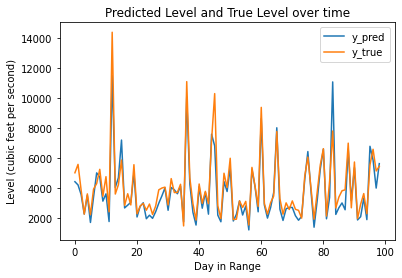

In [28]:
# Evaluation of the basic Conv2D model
evaluate_model(basic_conv_model)

The ConvLSTM2D model performed even better. It achieved a loss of 8.6609e-04. Results are shown below:

Test set loss:
76/76 [==============================] - 1s 9ms/step - loss: 0.0012
0.0012297757202759385


Predictions and true values for past 40 days:


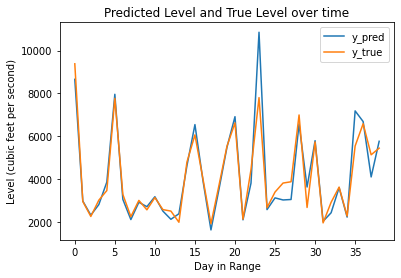


Predictions and true values for past 100 days:


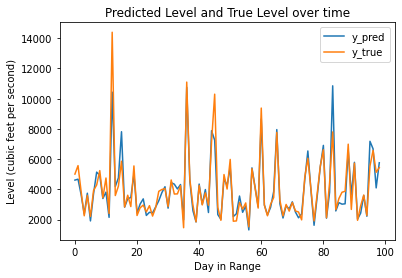

In [29]:
evaluate_model(conv_LSTM_model, X_test=X_test_5D)

## Results Discussion 
These results align perfectly with the underlying theory behind each model. RNN and CNN models both have their strengths, but both have limitations.

CNN models are able to find more complex relationships between features. Warm rainfall on a deep snowpack does much more than cold rain with bare mountains. Simpler models are likely to miss these intracacies. But, CNNs miss the sequential nature of the data, losing that information entirely.

RNN models are ideal for capturing the sequential nature of the data. Rain on dry ground may not affect the level at all, while rain for the third day in the row falling into saturated soil is far more likely to cause a change in level. But, RNNs may not be able to identify complex interactions between multiple features as readily as other models.

It is thus perfectly logical that by combining the two approaches, as done by the ConvLSTM2D model, the strengths of both approaches can be leveraged while mitigating the weaknesses. 





## Conclusion

This experiment very clearly demonstrated that river levels can be accurately modeled with neural networks to a high degree of accuracy. However, these results are limited to a single gauge on a single river and can only be used to predict daily average level up to 24 hours in advance. Before these results could hope to offer useful inference a variety of extensions would need to be pursued.

#### Potential Extensions:

*   Pull weather data from multiple stations at different points in the drainage
*   Use multiple gauges at different points on the same river
*   Use more input features (ie freezing elevation)
*   Retrain the model on other rivers/drainages
* Using a constructed model, build an actionable interface for making inferences/level predictions
* Synthesize future data based on weather forecast to make predictions further into the future
* Increase time interval frequency to get more specific inference (ie hourly predictions)

### 6) References
General ideas were adapted from the following:
* Aarya Tadvalkar, [Human Activity Recognition Using Accelerometer Data](https://kgptalkie.com/human-activity-recognition-using-accelerometer-data/)

* Jason Brownlee PhD, [How to Use Timesteps in LSTM Networks for Time Series Forecasting](https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/)

* Jason Brownlee PhD, [How to use Different Batch Sizes when Training and Predicting with LSTMs](https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/)